# Modelo de Classificação Antifraude
### O modelo de classificação tem o objetivo de identificar e classificar possiveis fraudes na base de dados

In [1]:
### Importando Bibliotecas 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
from catboost import CatBoostClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Análise exploratoria 

In [2]:
db = pd.read_csv('dados.csv')

print('\nInformações sobre a base de dados \n')
print(db.info())  
print('\nQuantidade de valores nulos\n')
print(db.isnull().sum()) 
print('\nDescrição e metricas\n')
print(db.describe()) 
print('\nMatriz de correlação\n')
corr = db.corr()
corr.style.background_gradient(cmap = 'PuBu')



Informações sobre a base de dados 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id_subestacao         150000 non-null  int64 
 1   local_medidor         150000 non-null  object
 2   tipo_medidor          150000 non-null  object
 3   consumo_medio_mensal  150000 non-null  int64 
 4   temperatura_maxima    150000 non-null  int64 
 5   temperatura_minima    150000 non-null  int64 
 6   numero_fases          150000 non-null  object
 7   classe_cliente        150000 non-null  object
dtypes: int64(4), object(4)
memory usage: 9.2+ MB
None

Quantidade de valores nulos

id_subestacao           0
local_medidor           0
tipo_medidor            0
consumo_medio_mensal    0
temperatura_maxima      0
temperatura_minima      0
numero_fases            0
classe_cliente          0
dtype: int64

Descrição e metricas

       id_sube

,id_subestacao,consumo_medio_mensal,temperatura_maxima,temperatura_minima
id_subestacao,1.000000,0.005612,-0.000589,0.002889
consumo_medio_mensal,0.005612,1.000000,0.003362,0.000735
temperatura_maxima,-0.000589,0.003362,1.000000,0.004018
temperatura_minima,0.002889,0.000735,0.004018,1.000000


#### Indicadores


In [3]:
## Verificando valores 
## Porcentagem de Fraudes na base

qtd = db.groupby('classe_cliente').count()
porcentagem = qtd.iloc[0] / qtd.iloc[1] 
print('Porcentagem de Fraude:', "{0:.0%}".format(porcentagem.values[0]))

fraude = db.query('classe_cliente == "fraudador"')
qtd_fraude = fraude.groupby('id_subestacao').count().mean().values[0]
print('Média de Fraudes por estações:',round(qtd_fraude,2))


Porcentagem de Fraude: 3%
Média de Fraudes por estações: 92.18


#### Gráficos

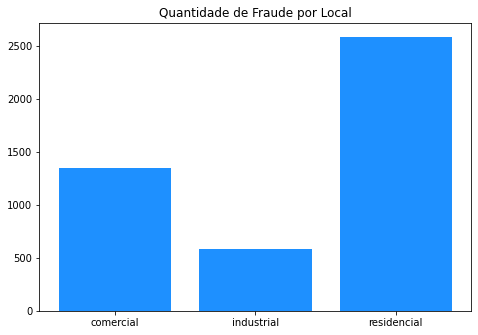

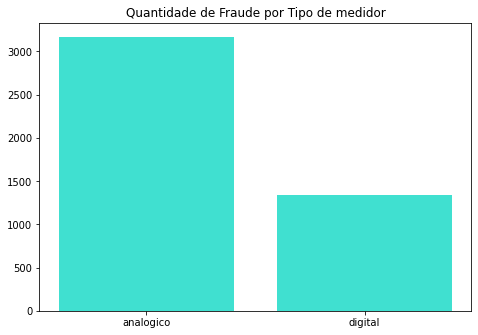

In [4]:
med_local = fraude.groupby('local_medidor').count().reset_index()
med_tipo = fraude.groupby('tipo_medidor').count().reset_index()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = med_local['local_medidor']
y = med_local['id_subestacao']
plt.title("Quantidade de Fraude por Local")
ax.bar(x,y,color ='dodgerblue')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = med_tipo['tipo_medidor']
y = med_tipo['id_subestacao']
plt.title("Quantidade de Fraude por Tipo de medidor")
ax.bar(x,y,color ='turquoise')
plt.show()



#### Tratamento dos dados

In [5]:
# Transformação de dados categoricos do tipo string para números

db.local_medidor = pd.Categorical(db.local_medidor)
db['local_medidor'] = db.local_medidor.cat.codes

db.tipo_medidor = pd.Categorical(db.tipo_medidor)
db['tipo_medidor'] = db.tipo_medidor.cat.codes

db.numero_fases = pd.Categorical(db.numero_fases)
db['numero_fases'] = db.numero_fases.cat.codes

db.classe_cliente = pd.Categorical(db.classe_cliente)
db['classe_cliente'] = db.classe_cliente.cat.codes

db.loc[db['consumo_medio_mensal'] >= 200, 'CMMAcima'] = 1
db.loc[db['consumo_medio_mensal'] < 200, 'CMMAbaixo'] = 1

db = db.fillna(0)

#### Correlação das Features

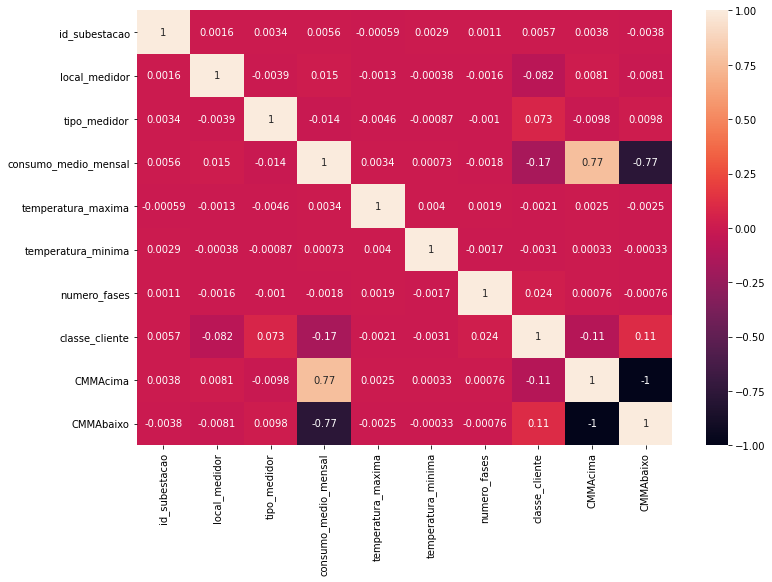

In [6]:
corr_df = db.corr(method='pearson')

plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True)
plt.show()

#### Features e Target

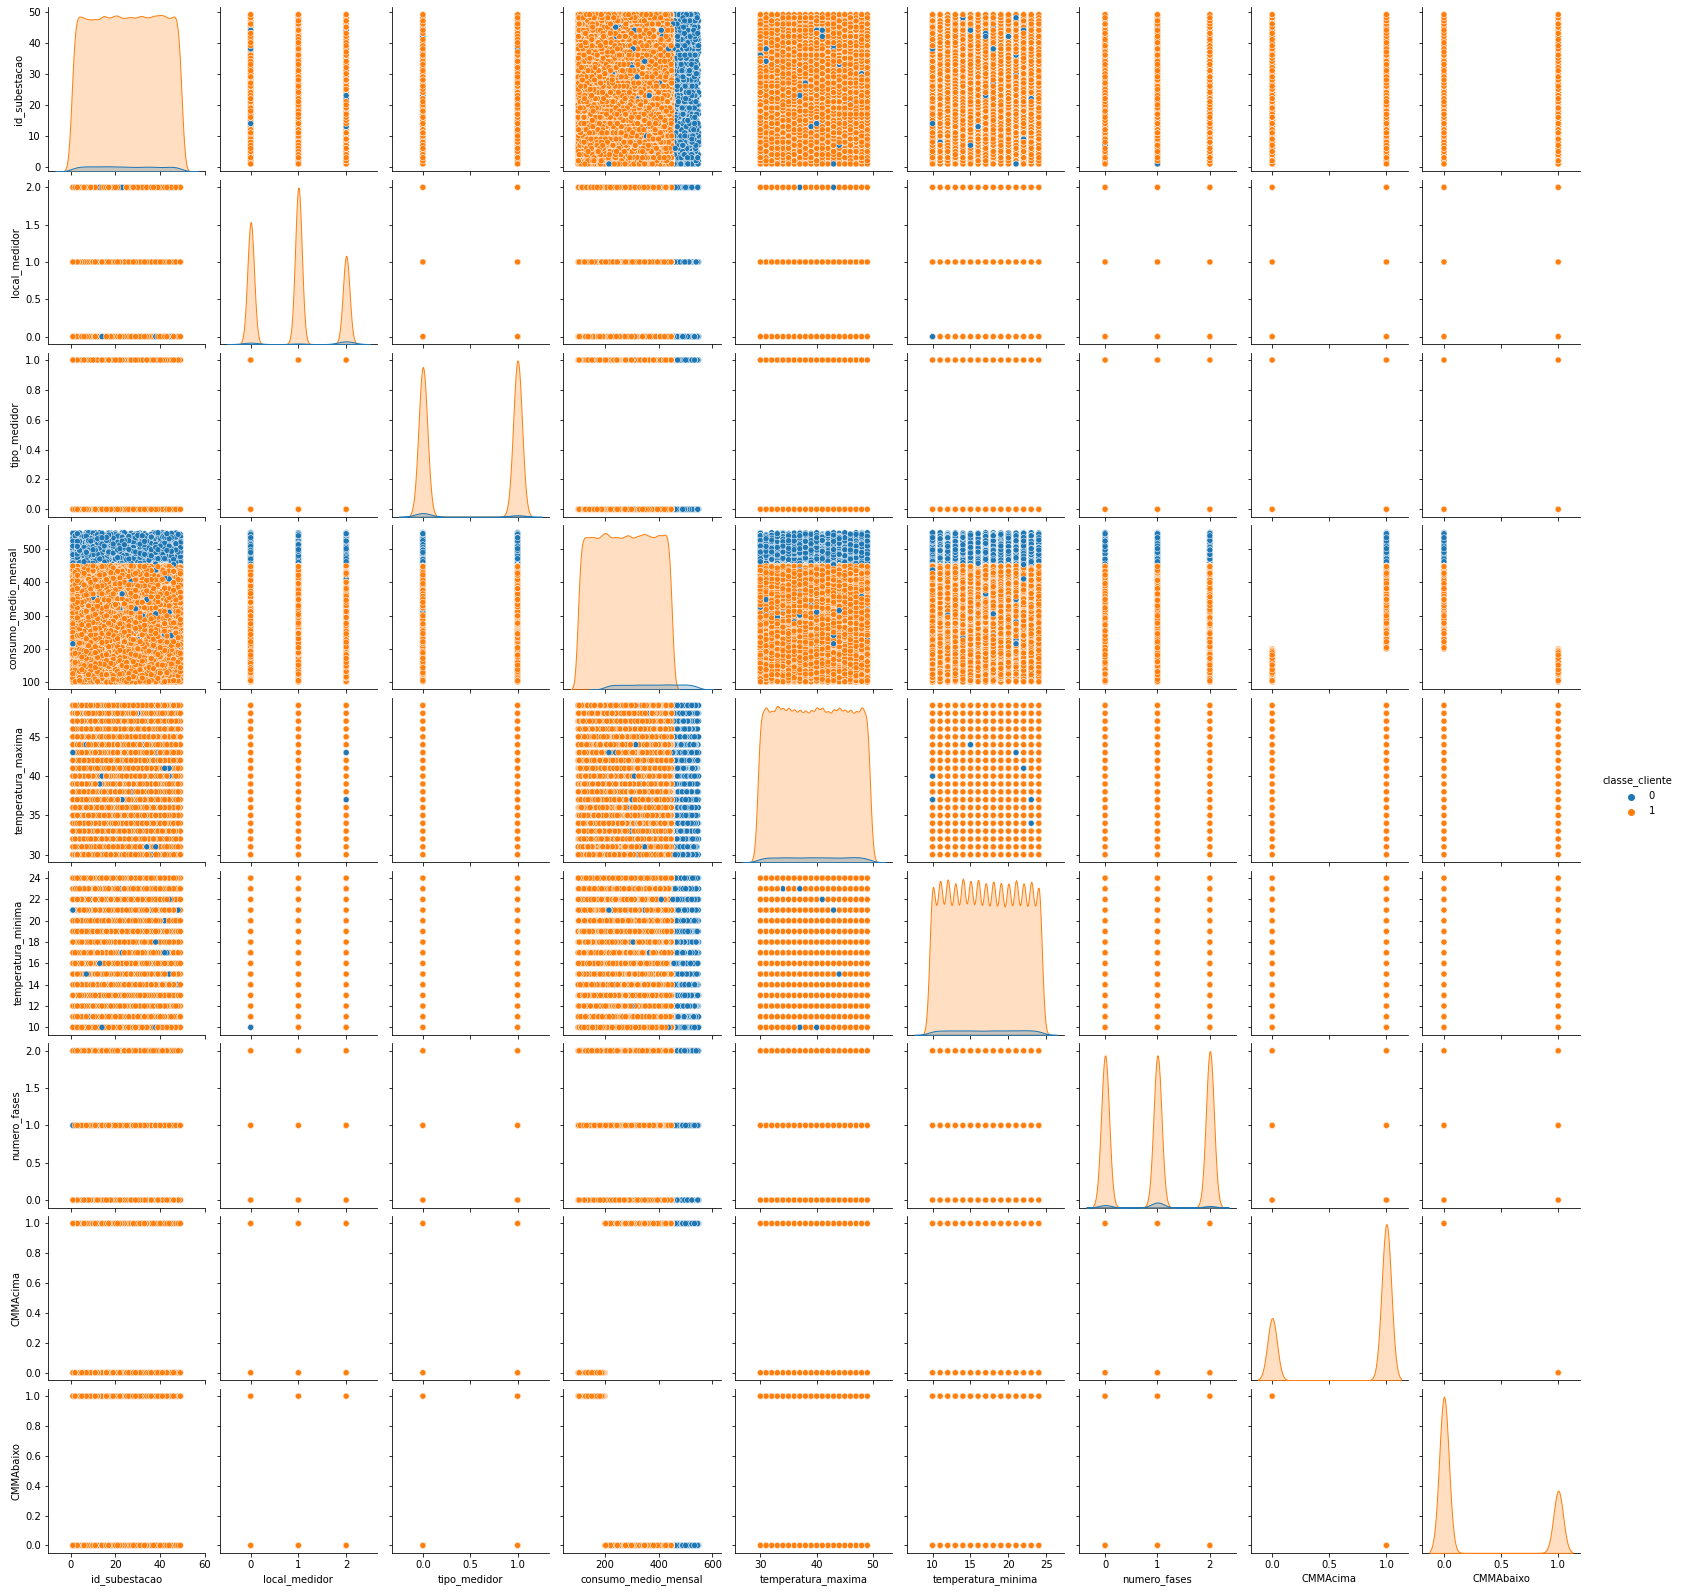

In [7]:
sns.pairplot(db, hue="classe_cliente")

#### Criação do modelo

In [8]:
X = db.drop('classe_cliente', axis=1)
y = db['classe_cliente']


X_trainT, X_testT, y_trainT, y_testT = train_test_split(X, y)

In [9]:
#Balanciamento dos dados

smt = SMOTE()
X, y = smt.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
#Treinando modelos 
modelResult = pd.DataFrame(index=['Random Florest'], columns=['Score'])

rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)
ypredRf = rf.predict(X_testT)

cat = CatBoostClassifier(
            learning_rate=0.2,
            depth=5,
            iterations=1000)
cat.fit(X_train, y_train)
ypredct = cat.predict(X_testT)

lr = LogisticRegression()
lr.fit(X_train, y_train)
ypredLr = lr.predict(X_testT)

0:	learn: 0.4849283	total: 74ms	remaining: 1m 13s
1:	learn: 0.4258137	total: 97.3ms	remaining: 48.6s
2:	learn: 0.3946653	total: 121ms	remaining: 40.1s
3:	learn: 0.3784458	total: 144ms	remaining: 35.9s
4:	learn: 0.3700062	total: 167ms	remaining: 33.2s
5:	learn: 0.3639730	total: 191ms	remaining: 31.6s
6:	learn: 0.3604105	total: 213ms	remaining: 30.2s
7:	learn: 0.3575097	total: 236ms	remaining: 29.3s
8:	learn: 0.3558844	total: 260ms	remaining: 28.6s
9:	learn: 0.3547332	total: 285ms	remaining: 28.2s
10:	learn: 0.3537414	total: 313ms	remaining: 28.1s
11:	learn: 0.3529374	total: 336ms	remaining: 27.7s
12:	learn: 0.3519524	total: 360ms	remaining: 27.3s
13:	learn: 0.3513343	total: 380ms	remaining: 26.8s
14:	learn: 0.3507623	total: 402ms	remaining: 26.4s
15:	learn: 0.3502862	total: 427ms	remaining: 26.3s
16:	learn: 0.3497906	total: 451ms	remaining: 26.1s
17:	learn: 0.3492562	total: 473ms	remaining: 25.8s
18:	learn: 0.3488627	total: 499ms	remaining: 25.8s
19:	learn: 0.3483983	total: 525ms	remain

163:	learn: 0.3165961	total: 3.91s	remaining: 19.9s
164:	learn: 0.3165083	total: 3.94s	remaining: 19.9s
165:	learn: 0.3163419	total: 3.97s	remaining: 19.9s
166:	learn: 0.3162151	total: 3.99s	remaining: 19.9s
167:	learn: 0.3160580	total: 4.02s	remaining: 19.9s
168:	learn: 0.3159647	total: 4.04s	remaining: 19.9s
169:	learn: 0.3158231	total: 4.07s	remaining: 19.9s
170:	learn: 0.3157044	total: 4.1s	remaining: 19.9s
171:	learn: 0.3155673	total: 4.13s	remaining: 19.9s
172:	learn: 0.3154205	total: 4.15s	remaining: 19.8s
173:	learn: 0.3153233	total: 4.18s	remaining: 19.8s
174:	learn: 0.3151750	total: 4.21s	remaining: 19.8s
175:	learn: 0.3150530	total: 4.24s	remaining: 19.8s
176:	learn: 0.3148977	total: 4.27s	remaining: 19.8s
177:	learn: 0.3147198	total: 4.29s	remaining: 19.8s
178:	learn: 0.3146068	total: 4.32s	remaining: 19.8s
179:	learn: 0.3145166	total: 4.35s	remaining: 19.8s
180:	learn: 0.3143409	total: 4.37s	remaining: 19.8s
181:	learn: 0.3142128	total: 4.4s	remaining: 19.8s
182:	learn: 0.

327:	learn: 0.2960204	total: 8.29s	remaining: 17s
328:	learn: 0.2958682	total: 8.31s	remaining: 17s
329:	learn: 0.2957303	total: 8.34s	remaining: 16.9s
330:	learn: 0.2955876	total: 8.37s	remaining: 16.9s
331:	learn: 0.2954761	total: 8.39s	remaining: 16.9s
332:	learn: 0.2953465	total: 8.42s	remaining: 16.9s
333:	learn: 0.2952481	total: 8.45s	remaining: 16.9s
334:	learn: 0.2950784	total: 8.48s	remaining: 16.8s
335:	learn: 0.2949922	total: 8.52s	remaining: 16.8s
336:	learn: 0.2948791	total: 8.56s	remaining: 16.8s
337:	learn: 0.2947749	total: 8.59s	remaining: 16.8s
338:	learn: 0.2946436	total: 8.62s	remaining: 16.8s
339:	learn: 0.2945519	total: 8.65s	remaining: 16.8s
340:	learn: 0.2944094	total: 8.67s	remaining: 16.8s
341:	learn: 0.2942744	total: 8.69s	remaining: 16.7s
342:	learn: 0.2941880	total: 8.72s	remaining: 16.7s
343:	learn: 0.2941025	total: 8.74s	remaining: 16.7s
344:	learn: 0.2939936	total: 8.77s	remaining: 16.6s
345:	learn: 0.2938877	total: 8.79s	remaining: 16.6s
346:	learn: 0.29

493:	learn: 0.2802773	total: 12.6s	remaining: 12.9s
494:	learn: 0.2802311	total: 12.6s	remaining: 12.9s
495:	learn: 0.2801439	total: 12.7s	remaining: 12.9s
496:	learn: 0.2800473	total: 12.7s	remaining: 12.8s
497:	learn: 0.2799601	total: 12.7s	remaining: 12.8s
498:	learn: 0.2798791	total: 12.8s	remaining: 12.8s
499:	learn: 0.2797438	total: 12.8s	remaining: 12.8s
500:	learn: 0.2796500	total: 12.8s	remaining: 12.8s
501:	learn: 0.2795793	total: 12.9s	remaining: 12.7s
502:	learn: 0.2794674	total: 12.9s	remaining: 12.7s
503:	learn: 0.2793887	total: 12.9s	remaining: 12.7s
504:	learn: 0.2793143	total: 12.9s	remaining: 12.7s
505:	learn: 0.2792607	total: 13s	remaining: 12.7s
506:	learn: 0.2791867	total: 13s	remaining: 12.6s
507:	learn: 0.2790858	total: 13s	remaining: 12.6s
508:	learn: 0.2789617	total: 13.1s	remaining: 12.6s
509:	learn: 0.2788961	total: 13.1s	remaining: 12.6s
510:	learn: 0.2788113	total: 13.1s	remaining: 12.5s
511:	learn: 0.2787561	total: 13.1s	remaining: 12.5s
512:	learn: 0.2786

655:	learn: 0.2681086	total: 17s	remaining: 8.92s
656:	learn: 0.2680496	total: 17s	remaining: 8.89s
657:	learn: 0.2679888	total: 17.1s	remaining: 8.87s
658:	learn: 0.2679105	total: 17.1s	remaining: 8.84s
659:	learn: 0.2678178	total: 17.1s	remaining: 8.81s
660:	learn: 0.2677425	total: 17.1s	remaining: 8.78s
661:	learn: 0.2676704	total: 17.1s	remaining: 8.76s
662:	learn: 0.2676271	total: 17.2s	remaining: 8.73s
663:	learn: 0.2675467	total: 17.2s	remaining: 8.7s
664:	learn: 0.2675106	total: 17.2s	remaining: 8.68s
665:	learn: 0.2674480	total: 17.2s	remaining: 8.65s
666:	learn: 0.2673860	total: 17.3s	remaining: 8.62s
667:	learn: 0.2673031	total: 17.3s	remaining: 8.6s
668:	learn: 0.2672368	total: 17.3s	remaining: 8.57s
669:	learn: 0.2671654	total: 17.3s	remaining: 8.54s
670:	learn: 0.2670538	total: 17.4s	remaining: 8.51s
671:	learn: 0.2669980	total: 17.4s	remaining: 8.48s
672:	learn: 0.2668745	total: 17.4s	remaining: 8.46s
673:	learn: 0.2668316	total: 17.4s	remaining: 8.43s
674:	learn: 0.2667

816:	learn: 0.2572359	total: 20.8s	remaining: 4.66s
817:	learn: 0.2571879	total: 20.8s	remaining: 4.63s
818:	learn: 0.2571025	total: 20.9s	remaining: 4.61s
819:	learn: 0.2570435	total: 20.9s	remaining: 4.58s
820:	learn: 0.2569865	total: 20.9s	remaining: 4.56s
821:	learn: 0.2569302	total: 20.9s	remaining: 4.53s
822:	learn: 0.2568569	total: 21s	remaining: 4.5s
823:	learn: 0.2567601	total: 21s	remaining: 4.48s
824:	learn: 0.2567056	total: 21s	remaining: 4.45s
825:	learn: 0.2566613	total: 21s	remaining: 4.43s
826:	learn: 0.2566008	total: 21s	remaining: 4.4s
827:	learn: 0.2565348	total: 21.1s	remaining: 4.38s
828:	learn: 0.2564784	total: 21.1s	remaining: 4.35s
829:	learn: 0.2563952	total: 21.1s	remaining: 4.32s
830:	learn: 0.2563434	total: 21.1s	remaining: 4.3s
831:	learn: 0.2562633	total: 21.2s	remaining: 4.27s
832:	learn: 0.2562319	total: 21.2s	remaining: 4.25s
833:	learn: 0.2561771	total: 21.2s	remaining: 4.22s
834:	learn: 0.2561095	total: 21.2s	remaining: 4.19s
835:	learn: 0.2560660	tot

978:	learn: 0.2476036	total: 24.7s	remaining: 530ms
979:	learn: 0.2475273	total: 24.7s	remaining: 505ms
980:	learn: 0.2474819	total: 24.7s	remaining: 479ms
981:	learn: 0.2474419	total: 24.8s	remaining: 454ms
982:	learn: 0.2473893	total: 24.8s	remaining: 429ms
983:	learn: 0.2473570	total: 24.8s	remaining: 403ms
984:	learn: 0.2473065	total: 24.8s	remaining: 378ms
985:	learn: 0.2472373	total: 24.9s	remaining: 353ms
986:	learn: 0.2471501	total: 24.9s	remaining: 328ms
987:	learn: 0.2470805	total: 24.9s	remaining: 303ms
988:	learn: 0.2470406	total: 24.9s	remaining: 277ms
989:	learn: 0.2469669	total: 25s	remaining: 252ms
990:	learn: 0.2468860	total: 25s	remaining: 227ms
991:	learn: 0.2468052	total: 25s	remaining: 202ms
992:	learn: 0.2467496	total: 25s	remaining: 176ms
993:	learn: 0.2466912	total: 25s	remaining: 151ms
994:	learn: 0.2466466	total: 25.1s	remaining: 126ms
995:	learn: 0.2465856	total: 25.1s	remaining: 101ms
996:	learn: 0.2465242	total: 25.1s	remaining: 75.6ms
997:	learn: 0.2464686

In [11]:
# Resultados dos modelos
modelResult.loc['Random Florest', 'Score'] = accuracy_score(ypredRf, y_testT, normalize=True)
modelResult.loc['Logistc Regression', 'Score'] = accuracy_score(ypredLr, y_testT, normalize=True)
modelResult.loc['Catboost', 'Score'] = accuracy_score(ypredct, y_testT,normalize=True)

print(modelResult)

                       Score
Random Florest      0.978987
Logistc Regression  0.736347
Catboost            0.845387


In [12]:
# Validação cruzada
result = []
for rep in range(10):
    kf = KFold(5, shuffle=True, random_state=rep)

for row_train, row_valid in kf.split(X):
    X_train, X_test = X.iloc[row_train], X.iloc[row_valid]
    y_train, y_test = y.iloc[row_train], y.iloc[row_valid]

    model = RandomForestClassifier(n_estimators = 100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_testT)
    acc = np.mean(y_testT == y_pred)
    result.append(acc)

In [13]:
#Resultados do modelo
print(np.mean(result))
print(classification_report(y_testT, y_pred))
print(pd.crosstab(y_testT, y_pred, rownames=['Real'], colnames=['Classificado'], margins=True))

0.9840906666666667
              precision    recall  f1-score   support

           0       0.67      0.96      0.79      1142
           1       1.00      0.99      0.99     36358

    accuracy                           0.98     37500
   macro avg       0.83      0.97      0.89     37500
weighted avg       0.99      0.98      0.99     37500

Classificado     0      1    All
Real                            
0             1093     49   1142
1              536  35822  36358
All           1629  35871  37500


#### Análise dos resultados

In [14]:
#Verificando os resultados
newdb = pd.DataFrame()
newdb['Real'] = y_testT
newdb['Pred'] = y_pred

newdb = pd.merge(db, newdb, how='right', left_index=True, right_index=True)

newdb['Equal'] = np.where(newdb["Real"] == newdb["Pred"], True, False)
newdb = newdb.query('Equal == False')

print('Falsos positivo:' ,newdb.query('Pred == 1').count().values[0])
print('Falsos negativos:' ,newdb.query('Pred == 0').count().values[0])
pd.set_option('max_columns',None)
print(newdb.query('Pred == 0'))

Falsos positivo: 49
Falsos negativos: 536
        id_subestacao  local_medidor  tipo_medidor  consumo_medio_mensal  \
19350              19              0             0                   407   
122645             18              1             0                   245   
119773             40              0             0                   274   
122185             12              2             0                   341   
41367              45              1             0                   401   
...               ...            ...           ...                   ...   
133583             46              0             0                   320   
89395               2              1             0                   255   
115990             38              0             0                   439   
2495               36              0             0                   203   
86526               7              0             0                   402   

        temperatura_maxima  temperatura_minim

#### Conclusão
##### O modelo teve um bom desempenho, forama feitos alguns testes para seleção das features. A coluna consumo_medio_mensal interfere nos resultados do modelo, porém 